# Range Stove Thermocouple Analysis

This Python notebook details a data analysis performed on Computational Fluid Dynamics (CFD) simulation data. This data is extracted from a cooktop simulation built with real-world methods. It is representative but has no explicit connection to *any* existing cooktop.

Standard thermal analysis for cooktop design uses several thermocouples in key locations inside and outside the stovetop. When performing a simulation, the cooktop starts in a room-temperature enviornment, heats up as the burners are lit, and eventually approaches a relative steady state.

Realistically, there are unsteady elements in a system of this complexity - airflow is inherently unstable in this turbulent / laminar regieme. Even though this model has been run steady-state (eliminating all contributions from time-dependent terms), periodic instabilities add noise to sensor readings.


### Goal:

The goal of this anaylsis is to properly predict convergence. While the relative error for the mass, momentum, and energy solvers dropped sufficiently by roughly 5000 iterations, the thermocouple measurements in the system indicate the model's temperature values increase for many iterations longer. 

In short, **at what iteration can the thermocouple data be trusted** as a final, steady-state value? This will indicate when this information can be confidently used in **data-backed decision making**.

## Raw Thermocouple Data

Thermocouple data was recorded at each iteration of the flow solver. Raw data was taken from the thermocouple near each of the following locations:
-  inside the oven, near the bottom rack
-  close to the cooktop burners
- on the exterior of the glass oven window
-  inside the electronics readout (above the cooktop)
-  below the broiler, near the top of the oven cavity

In [1]:
# from pandas import *  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
%matplotlib inline

# import data
np.seterr(divide='ignore', invalid='ignore')      # numpy error handling
mydata = np.genfromtxt('./stats_cooktop/temperatureThermocouples.csv', delimiter=',') # import

## Columns: 
#0: Iteration
#1: Broiler
#2: Oven Rack, lower
#3: Cooktop
#4: Electronics
#5: Glass Oven Window

i = mydata[:,0]
oven_rack = mydata[:,1]
cooktop  = mydata[:,2]
glass_window= mydata[:,3]
elec = mydata[:,4]
broiler = mydata[:,5]

# assemble dataframe

df = pd.DataFrame(data = mydata, columns = ['iteration', 'oven_rack', 'cooktop', 'glass_window', 'electronics', 'broiler'
 ])

# df

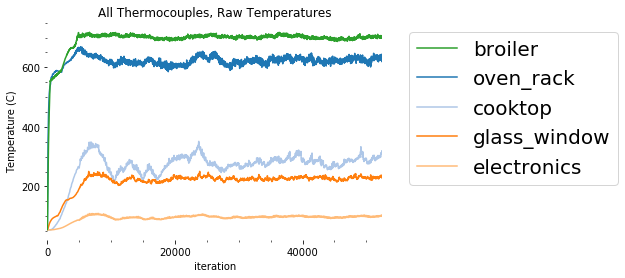

In [2]:
### Plot raw data  ####

# Use Tableau 20 colors as RGB
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 

# something's screwy in here, two plots, first one gets all the axis changes. why?
# Scale those RGB values to [0,1] -> matplotlib format
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  
    
    
# Limit data range to actual data range
m = df.max()        # get max value for each column individually
xlim = m[1:6].max() # take the max of the maxes, ignoring 'Iteration' column
 


### Plots
# all at once
ax = df.plot(x='iteration',
         title='All Thermocouples, Raw Temperatures', 
         color=tableau20,   # color scheme
         lw = 1.5,      #line weight
       )

# Run/Configure params = rcParams
### note: setting these does generate a plt in the background, I think. So doing
### this before plotting yields TWO plots, one of which (only one) gets the axis
### details

plt.rcParams["figure.figsize"] = (16,9)     # set figure size
plt.rcParams["font.size"]=20                # set font size
plt.ylabel('Temperature (C)')



# Remove plot frame, 
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# # Use axis tics only on bottom, left edges of plot
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.minorticks_on()
# fix legend to match order of temp, descending

handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.05, 1)) #bbox_to_anchor= off chart



# http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/


## Data Analysis: Broiler, Oven Rack, and Cooktop

Based on the above raw data, three thermocouples are the noisiest and slowest to converge. To ensure meaningful insights, the Broiler, Oven Rack, and Cooktop thermocouples must reach an approximate steady-state value.

For each thermocouple, the raw data is plotted for the sake of comparison. The rolling mean, taken over the last N=1000 iterations at any given point, becomes level when the sample mean stops changing over a given sample interval. 

The coefficient of variation represents the average amount any one datapoint varies from the sample mean, normalized by the sample mean (per window: standard deviation / mean). Similarly, once this value becomes constant, the data can be assumed to have reached its periodic steady-state.

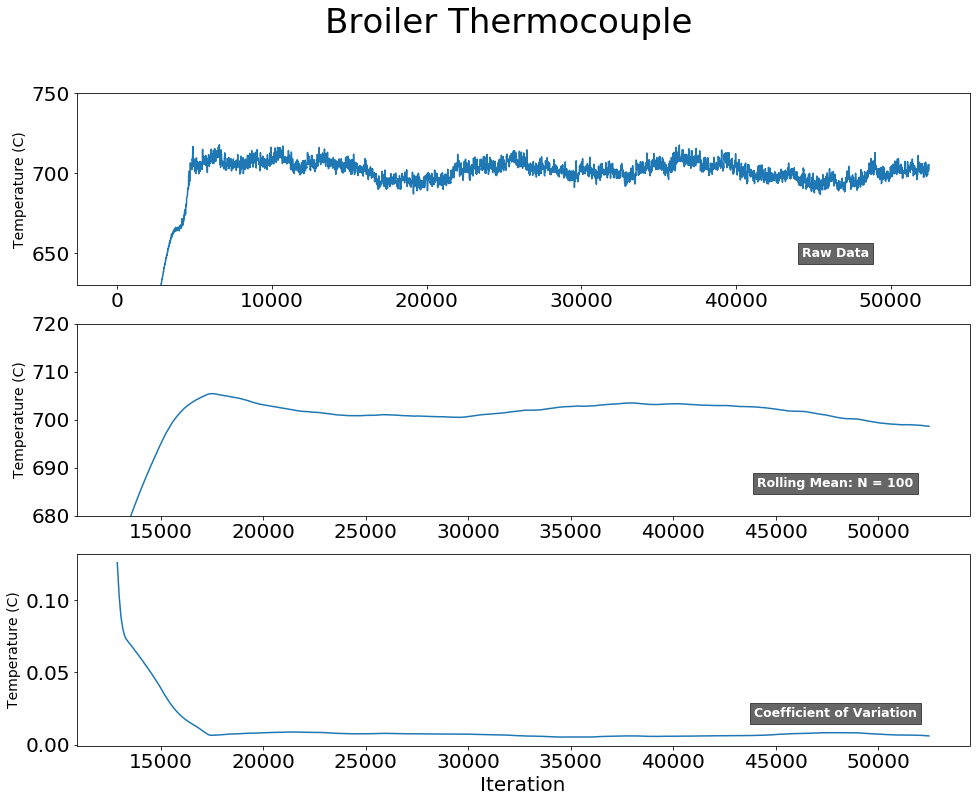

In [3]:
### Convergence by TC: broiler ### 
N = 1000  # sample window size

def add_titlebox_long(ax, text):
    ax.text(.85, .15, text,
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='black', alpha=0.6),
        fontsize=12.5, weight = 'bold', color = 'white')
    return ax

def add_titlebox_custom(x,y,size, ax, text):
    ax.text(x, y, text,
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.6,
           edgecolor ='none'),
        fontsize=size, weight = 'bold', color = 'Gray')
    return ax

# generate columns for rolling mean, rolling window's STD
df['rm_broiler'] = df['broiler'].rolling(N).mean() #get mean of window N
df['std_broiler']= df['broiler'].rolling(N).std()  #get standard dev of that window

#coefficient of variation - % variation of the mean
df['coeffVar_broiler'] = df['std_broiler'] / df['rm_broiler'] 

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (16,12))
fig.suptitle('Broiler Thermocouple', size=34)

#ax 1 - Raw Data
ax1.plot(df['iteration'],df['broiler'])
ax1.set_ylim(630,750)
ax1.set_ylabel('Temperature (C)', size=14)
add_titlebox_long(ax1, 'Raw Data')

#ax 2 - Rolling Mean
ax2.plot(df['iteration'],df['rm_broiler'])
ax2.set_ylim(680,720)

#ax2.set_ylim(600,640)
ax2.set_ylabel('Temperature (C)', size=14)
add_titlebox_long(ax2, 'Rolling Mean: N = 100')

#ax 1 - STD
ax3.plot(df['iteration'],df['coeffVar_broiler'])
#ax3.set_ylim(580,660)
ax3.set_ylabel('Temperature (C)', size=14)
ax3.set_xlabel('Iteration')
add_titlebox_long(ax3, 'Coefficient of Variation')
# plt.tight_layout()




# gridsize = (3,1)
# fig = plt.figure(figsize=(12,8))
# plt.suptitle('broiler Thermocouple')
# ax1 = plt.subplot2grid(gridsize,(0,0))
# ax2 = plt.subplot2grid(gridsize,(1,0))
# ax3 = plt.subplot2grid(gridsize,(2,0))                      

# ax1.plot(df['Iteration'],df['broiler'], ylim=(200,800))
#     #x='Iteration', title = 'broiler TC Raw',xlim=(0,3000))


#  # display raw broiler TC
# df[['Iteration','rm_broiler']].plot(x='Iteration', title='broiler Rolling Mean, N = 100',xlim=(0,3000),ylim=(550,700))
# df[['Iteration','std_broiler']].plot(x='Iteration', title='broiler TC STD, N = 100',xlim=(0,3000),ylim=(3,25))

# Explore this for various values of N, plot all series on one graph to find what
# TC we waited for!


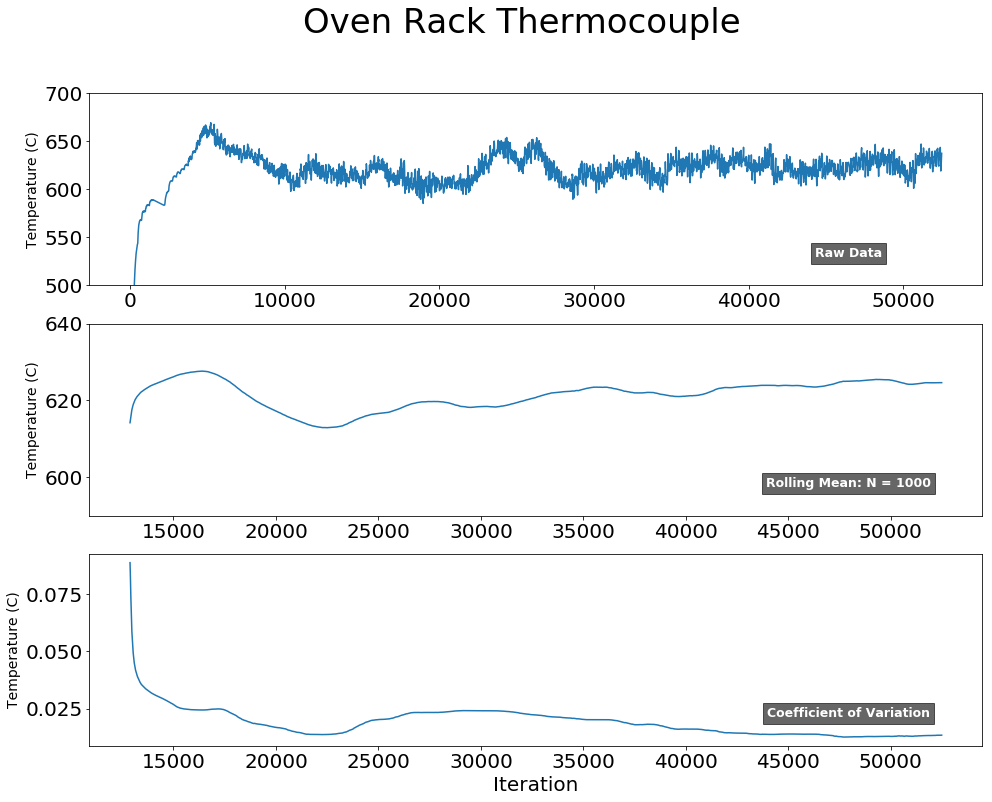

In [4]:
### Convergence by TC: oven_rack ### 
N = 1000  # sample window size

# generate columns for rolling mean, rolling window's STD
df['rm_oven_rack'] = df['oven_rack'].rolling(N).mean() #get mean of window N
df['std_oven_rack']= df['oven_rack'].rolling(N).std()  #get standard dev of that window

#coefficient of variation - % variation of the mean
df['coeffVar_oven_rack'] = df['std_oven_rack'] / df['rm_oven_rack']  

fig2, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (16,12))
fig2.suptitle('Oven Rack Thermocouple', size=34)






#ax 1 - Raw Data
ax1.plot(df['iteration'],df['oven_rack'])
ax1.set_ylim(500,700)
ax1.set_ylabel('Temperature (C)', size=14)
add_titlebox_long(ax1, 'Raw Data')

#ax 2 - Rolling Mean
ax2.plot(df['iteration'],df['rm_oven_rack'])
ax2.set_ylim(590,640)

#ax2.set_ylim(600,640)
ax2.set_ylabel('Temperature (C)', size=14)
add_titlebox_long(ax2, 'Rolling Mean: N = 1000')

#ax 1 - STD
ax3.plot(df['iteration'],df['coeffVar_oven_rack'])
#ax3.set_ylim(580,660)
ax3.set_ylabel('Temperature (C)', size=14)
ax3.set_xlabel('Iteration')
add_titlebox_long(ax3, 'Coefficient of Variation')
# plt.tight_layout()

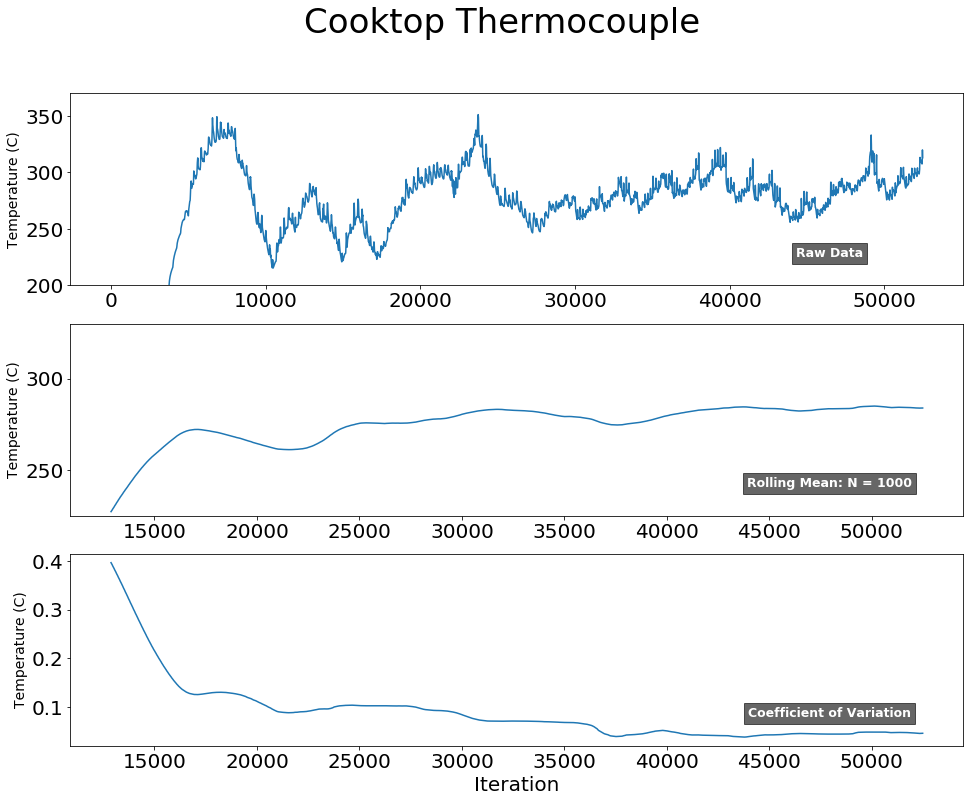

In [5]:
### Convergence by TC: cooktop ### 
N = 1000  # sample window size


# generate columns for rolling mean, rolling window's STD
df['rm_cooktop'] = df['cooktop'].rolling(N).mean() #get mean of window N
df['std_cooktop']= df['cooktop'].rolling(N).std()  #get standard dev of that window

#coefficient of variation - % variation of the mean
df['coeffVar_cooktop'] = df['std_cooktop'] / df['rm_cooktop']  

fig3, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (16,12))
fig3.suptitle('Cooktop Thermocouple', size=34)

#ax 1 - Raw Data
ax1.plot(df['iteration'],df['cooktop'])
ax1.set_ylim(200,370)
ax1.set_ylabel('Temperature (C)', size=14)
add_titlebox_long(ax1, 'Raw Data')

#ax 2 - Rolling Mean
ax2.plot(df['iteration'],df['rm_cooktop'])
ax2.set_ylim(225,330)
ax2.set_ylabel('Temperature (C)', size=14)
add_titlebox_long(ax2, 'Rolling Mean: N = 1000')

#ax 1 - STD
ax3.plot(df['iteration'],df['coeffVar_cooktop'])
#ax3.set_ylim(580,660)
ax3.set_ylabel('Temperature (C)', size=14)
ax3.set_xlabel('Iteration')
add_titlebox_long(ax3, 'Coefficient of Variation')
# plt.tight_layout()

### Analysis

The broiler and oven rack thermocouples converge by 8000 iterations. While the cooktop thermocouple always remains noisy and periodic, by iteration 40,000 the data shows signs of oscillating about an approximate mean. 

In this case, extracting data about the time of solver converge would be extremely inaccurate. By 5000 iterations, the cooktop thermcouple has only reached 

The solver converges near 5000 iterations. At that point, the cooktop thermocouple is still 20C from it's eventual mean of 283

,iteration,oven_rack,cooktop,glass_window,electronics,broiler,rm_broiler,std_broiler,coeffVar_broiler,rm_oven_rack,std_oven_rack,coeffVar_oven_rack,rm_cooktop,std_cooktop,coeffVar_cooktop,norm_oven_rack,norm_cooktop,norm_broiler
386,4980.0,653.737695,263.941156,192.034631,86.471368,705.778589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.046588,0.929811,1.010244
387,4995.0,662.061121,262.705316,192.225854,86.186548,708.924524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.059914,0.925457,1.014747
388,5005.0,662.468774,261.564081,192.322412,85.883691,701.811365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.060566,0.921437,1.004565
389,5020.0,662.546411,265.214807,193.412836,86.271265,704.952539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.060691,0.934298,1.009061


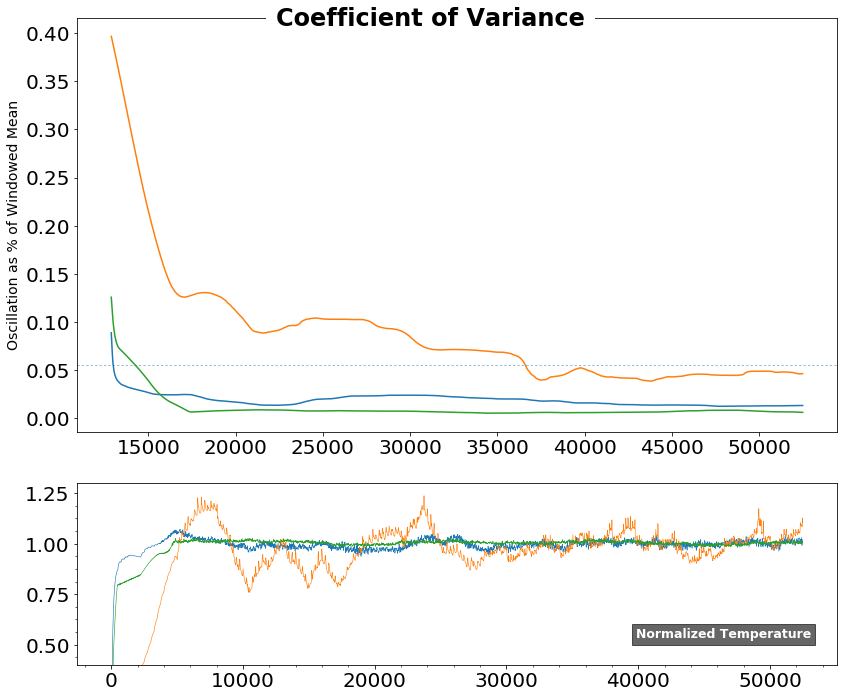

In [6]:
gridsize = (3,2)


fig = plt.figure(figsize=(12,10))
ax1 = plt.subplot2grid(gridsize, (0,0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize,(2,0), colspan=2,rowspan =1)
# ax3 = plt.subplot2grid(gridsize,(2,1))

fig.suptitle('Coefficient of Variance', weight='bold', bbox={'facecolor':'white', 'edgecolor':'none', 'pad':10})



#ax 1 - Coefficient of Variance: noisest three series
ax1.plot(df['iteration'],df['coeffVar_oven_rack'], label = 'Oven Rack')
ax1.plot(df['iteration'],df['coeffVar_cooktop'], label = 'Cooktop')
ax1.plot(df['iteration'],df['coeffVar_broiler'], label = 'Broiler')

# ax1.set_title('Coefficient of Variance, N = 1000', size =20)
ax1.set_ylabel('Oscillation as % of Windowed Mean', size=14)
ax1.axhline(y =.055, linestyle = ':', linewidth=.5)



#ax 2 - Raw Data, normalized by windowed mean of last 1000 values
df['norm_oven_rack'] = df['oven_rack'] / df['rm_oven_rack'].iloc[-1] 
df['norm_cooktop'] = df['cooktop'] / df['rm_cooktop'].iloc[-1] 
df['norm_broiler'] = df['broiler'] / df['rm_broiler'].iloc[-1] 

ax2.plot(df['iteration'],df['norm_oven_rack'], label = 'Oven Rack',lw=.6)
ax2.plot(df['iteration'],df['norm_cooktop'], label = 'Cooktop',lw=.6)
ax2.plot(df['iteration'],df['norm_broiler'], label = 'Broiler',lw=.6)


# ax2.set_ylabel('Normalized Temperature', size=14)
ax2.set_ylim(.4,1.3)
# add_titlebox_custom(.65,.65, 20, ax1, 'Coefficient of Variance, N = 1000')
# add_titlebox_custom(.65,.25, 14.5, ax2, 'Normalized Temperature')
add_titlebox_long(ax2, 'Normalized Temperature')

ax2.minorticks_on() # required for minor grid
# ax2.grid(which='minor', linestyle=':', linewidth='.4', color ='gray')  # gridlines
# ax2.grid(which='major', linestyle='-', linewidth='.4', color ='black', alpha = .4)  # gridlines




plt.tight_layout()



df.loc[386:389] # show data about 5000 iterations
# df.loc[4069]

